# Assignment 5

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Library Imports**

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import cv2
from tqdm import tqdm
import pandas as pd
from IPython.core.display import display, HTML
from sklearn.metrics import confusion_matrix,f1_score

**Data Loading**

In [0]:
data_dir = '/content/drive/My Drive/Assignment 5 Dataset'

In [18]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224,interpolation=3),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                      torchvision.transforms.Resize(size = 224, interpolation=3),
                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform = train_transforms)
test_data = datasets.ImageFolder(data_dir+ '/test', transform= test_transforms )

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=5)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=5)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle=True, num_workers=5)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [0]:
# plt.imshow(test_data[100][0].numpy().T)

**One batch Explore**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


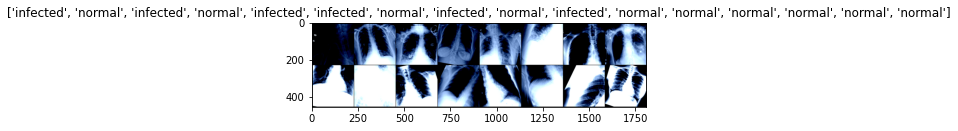

tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])


In [20]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.axis('off')
    plt.imshow(inp,cmap = 'gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)
print(classes)

In [21]:
classes

tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

### **Methods Definition**

In [0]:
def calculate_accuracy(loader_data, type_of_loader, model_uc,  return_loss_parameter_criterion = None):
  correct = 0
  total = 0
  accuracy = 0
  loss = 0
  loss_i = 0
  
  with torch.no_grad():
    if type_of_loader == 'Testing':
      for data in tqdm(loader_data, position = 0, leave = True):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_uc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      print('\n')      
    else:
      for data in loader_data:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_uc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if not return_loss_parameter_criterion is None:
          t_loss = return_loss_parameter_criterion(outputs, labels)
          loss += t_loss.item()
          loss_i +=1
    accuracy = correct / total *100

    print('\t \t Accuracy %s images: %.1f %%' % ( type_of_loader,
                                             accuracy))
    if not return_loss_parameter_criterion is None:
      return accuracy, loss/loss_i

  return accuracy 



In [0]:
def model_training(model_loaded,
                   train_data_loader , validation_data_loader,
                   no_of_epochs, criterion_function,
                   optimizer_function, model_name_to_save,
                   plot_graphs):
  train_accuracy = []
  validation_accuracy = []

  train_loss = []
  validation_loss = []
  # Loss and Optimizer function

  Epochs = no_of_epochs
  criterion = criterion_function
  optimizer = optimizer_function

  trainloader = train_data_loader
  validationloader =  validation_data_loader

  #if you have gpu then you need to convert the network and data to cuda
  #the easiest way is to first check for device and then convert network and data to device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model_loaded.to(device)

  

  for epoch in range(Epochs):  # loop over the dataset multiple times
    model_loaded.train()
    loss_i = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader),  leave=True,position = 0 )
    for i, data in pbar:
    
      # get the inputs
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
      # because PyTorch accumulates the gradients on subsequent backward passes. 
      # This is convenient while training RNNs. 
      # So, the default action is to accumulate the gradients on every loss.backward() call

      # forward + backward + optimize
      outputs = model_loaded(inputs)               #----> forward pass
      loss = criterion(outputs, labels)   #----> compute loss
      loss.backward()                     #----> backward pass
      optimizer.step()                    #----> weights update

      # print statistics
      running_loss += loss.item()
      loss_i +=1
      pbar.set_description(
          'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, i * len(inputs), len(trainloader.dataset),
              100. * i / len(trainloader),
              loss.item() ))
    train_accuracy.append(calculate_accuracy(trainloader , "Training", model_loaded))

    valAccuracy_rcvd, val_loss_rcvd =  calculate_accuracy(validationloader , "Validation", model_loaded, criterion )
    validation_accuracy.append(valAccuracy_rcvd)

    train_loss.append(running_loss/loss_i)
    validation_loss.append(val_loss_rcvd)



  torch.save(model_loaded.state_dict(), str(model_name_to_save) +'.pth')

  print('Finished Training')

  if plot_graphs == True:
    plt.figure(figsize =  (8,8))
    plt.title(' Accuracy plot')
    plt.subplot(121)
    plt.plot(np.arange(Epochs), train_accuracy, label = 'Train Accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('Epochs')
    plt.legend()
    plt.title('Train Accuracy over Epochs')
    plt.ylim( (0,100))  
  

    plt.subplot(122)
    plt.plot(np.arange(Epochs), validation_accuracy, label = 'Validation Accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('Epochs')
    plt.legend()
    plt.title('Validation Accuracy over Epochs')
    plt.ylim( (0,100))  

    plt.figure(figsize =  (8,8))
    
    plt.title(' Loss plot')
    plt.subplot(121)
    plt.plot(np.arange(Epochs), train_loss, label = 'Train Loss')
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.legend()
    plt.title('Train Loss over Epochs')
    

    plt.subplot(122)
    plt.plot(np.arange(Epochs), validation_loss, label = 'Validation Loss')
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.legend()
    plt.title('Validation Loss over Epochs')
    

In [0]:
def Confusion_Matrix_F1 (loader_data, type_of_loader, model_uc):
  correct = 0
  total = 0
  accuracy = 0

  label = []
  predict = []
  with torch.no_grad():
    for data in tqdm(loader_data, position = 0, leave = True):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model_uc(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
      label.extend( list(labels.cpu().numpy()) )
      predict.extend( list(predicted.cpu().numpy()) )
  
  accuracy = correct / total *100
  label = np.array(label)
  predict = np.array(predict)
  
  cfm = confusion_matrix(label, predict)
  f1Score = f1_score(label, predict)
  
  df = pd.DataFrame(cfm,columns=['Predicted Infected','Predicted Normal'], index = ['Actual Infected','Actual Normal'])
  
  display(HTML('<h3>'+ str(type_of_loader) +'<br></h3>'))
  display(HTML('<h4>Confusion Matrix <br></h4>'))
  display(df)
  display(HTML('<h4> F1 Score is : ' + str(f1Score)[:5] +' </h4>'))
  display(HTML('<h4> Accuracy    : ' + str(accuracy)[:5] +' </h4>'))


In [0]:
def right_and_wrong_images(loader_data, type_of_loader, model_uc):
  label = []
  predict = []
  image = []
  with torch.no_grad():
    for data in tqdm(loader_data, position = 0, leave = True):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model_uc(images)
      _, predicted = torch.max(outputs.data, 1)
      
      label.extend( list(labels.cpu().numpy()) )
      predict.extend( list(predicted.cpu().numpy()) )
      image.extend( list(images.cpu().numpy()) )

  label = np.array(label)
  predict = np.array(predict)

  correct_pred = (predict == label)
  wrong_pred = (predict != label )
  
  class1_correct = np.intersect1d(np.nonzero( (correct_pred ==1))[0], np.nonzero( (label == 1 ))[0])[:2]
  class2_correct = np.intersect1d( np.nonzero( (correct_pred ==1))[0], np.nonzero( (label == 0 ))[0])[:2]

  class1_wrong = np.intersect1d( np.nonzero( (wrong_pred ==1))[0], np.nonzero( (label == 1 ))[0])[:2]
  class2_wrong = np.intersect1d( np.nonzero( (wrong_pred ==1))[0], np.nonzero( (label == 0 ))[0])[:2]
  
  fig,ax = plt.subplots(1,2)
  
  print('\nCorrect Normal prediction indices',class1_correct)
  print('True Labels are                  ',label[class1_correct],)
  print('And Predicted Labels are         ',predict[class1_correct],)

  for i in range(2):
    ax[i].imshow(image[class1_correct[i]].T )
  fig.suptitle('Correct Normal prediction')
  
  print('\nCorrect Infected prediction indices',class2_correct)
  print('True Labels are                  ',label[class2_correct],)
  print('And Predicted Labels are         ',predict[class2_correct],)

  
  fig,ax = plt.subplots(1,2)
  for i in range(2):
    ax[i].imshow(image[class2_correct[i]].T )
  fig.suptitle('Correct Infected prediction')
  
  
  print('\nWrong Normal prediction indices',class1_wrong)
  print('True Labels are                  ',label[class1_wrong],)
  print('And Predicted Labels are         ',predict[class1_wrong],)

  
  fig,ax = plt.subplots(1,2)
  for i in range(2):
    ax[i].imshow(image[class1_wrong[i]].T )
  fig.suptitle('Wrong Normal prediction')
  
  print('\nWrong Infected prediction indices',class2_wrong)
  print('True Labels are                  ',label[class2_wrong],)
  print('And Predicted Labels are         ',predict[class2_wrong],)

  
  fig,ax = plt.subplots(1,2)
  for i in range(2):
    ax[i].imshow(image[class2_wrong[i]].T )
  fig.suptitle('Wrong Infected prediction')
  
    

**Device Loading**

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## TASK 1

### VGG 16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

In [0]:
# Freeze training for all features_layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [42]:
num_features = ( 43 * 10) + 100
features = list(vgg16.classifier.children())[:4] # Remove  layers except first one with activation layer
features[0].out_features =num_features
features[0].in_features =(25088,4096) # the dimension of input tensor to first FCL is   7x7x512x4096 = (25088, 4096)

print(features)

[Linear(in_features=(25088, 4096), out_features=530, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True)]


In [0]:
features[-1].out_features = len(class_names)
features[-1].in_features = num_features

In [44]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)
print(vgg16.classifier[-1].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG16 Model Training Started 


Train Epoch: 0 [7876/11467 (100%)]	Loss: 0.221957: : 717it [02:03,  5.82it/s]


	 	 Accuracy Training images: 84.7 %
	 	 Accuracy Validation images: 81.7 %


Train Epoch: 1 [7876/11467 (100%)]	Loss: 0.477621: : 717it [02:01,  5.90it/s]


	 	 Accuracy Training images: 84.8 %
	 	 Accuracy Validation images: 82.6 %


Train Epoch: 2 [7876/11467 (100%)]	Loss: 0.214715: : 717it [01:57,  6.09it/s]


	 	 Accuracy Training images: 85.6 %
	 	 Accuracy Validation images: 83.4 %


Train Epoch: 3 [7876/11467 (100%)]	Loss: 0.340547: : 717it [01:57,  6.08it/s]


	 	 Accuracy Training images: 86.3 %
	 	 Accuracy Validation images: 84.1 %


Train Epoch: 4 [7876/11467 (100%)]	Loss: 0.199755: : 717it [01:59,  5.98it/s]


	 	 Accuracy Training images: 84.5 %
	 	 Accuracy Validation images: 82.4 %


Train Epoch: 5 [7876/11467 (100%)]	Loss: 0.372754: : 717it [01:58,  6.06it/s]


	 	 Accuracy Training images: 82.2 %
	 	 Accuracy Validation images: 78.9 %


Train Epoch: 6 [7876/11467 (100%)]	Loss: 0.360043: : 717it [01:57,  6.10it/s]


	 	 Accuracy Training images: 86.6 %
	 	 Accuracy Validation images: 85.1 %


Train Epoch: 7 [7876/11467 (100%)]	Loss: 0.318708: : 717it [02:00,  5.96it/s]


	 	 Accuracy Training images: 87.1 %
	 	 Accuracy Validation images: 85.1 %


Train Epoch: 8 [7876/11467 (100%)]	Loss: 0.094143: : 717it [02:00,  5.97it/s]


	 	 Accuracy Training images: 86.8 %
	 	 Accuracy Validation images: 83.7 %


Train Epoch: 9 [7876/11467 (100%)]	Loss: 0.527734: : 717it [01:58,  6.06it/s]


	 	 Accuracy Training images: 87.5 %
	 	 Accuracy Validation images: 85.3 %


  0%|          | 0/94 [00:00<?, ?it/s]

Finished Training

  Test Accuracy : 


  0%|          | 0/717 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 92.4 %

  Confusion Matrices :


100%|██████████| 717/717 [01:54<00:00,  6.24it/s]


Predicted Infected  Predicted Normal
Actual Infected                4096               823
Actual Normal                   610              5938

100%|██████████| 94/94 [00:14<00:00,  6.36it/s]


Predicted Infected  Predicted Normal
Actual Infected                 507               108
Actual Normal                   139               746

100%|██████████| 94/94 [00:13<00:00,  6.95it/s]


Predicted Infected  Predicted Normal
Actual Infected                 534                81
Actual Normal                    25               860

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:13<00:00,  6.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [2 9]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [1 3]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [21 75]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [0 7]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


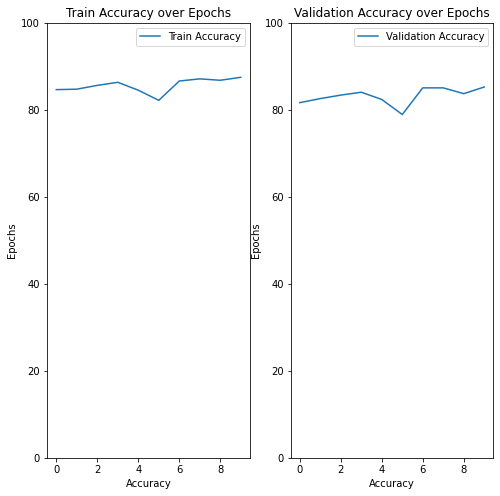

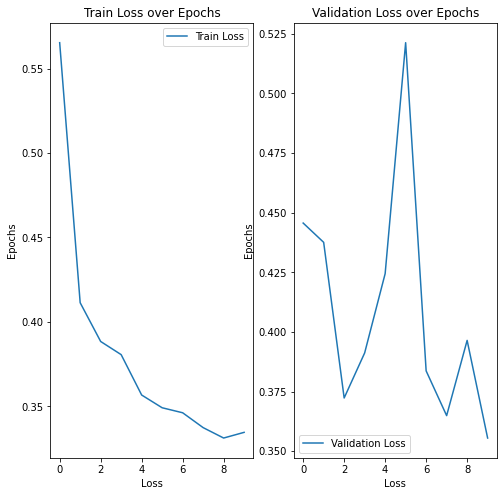

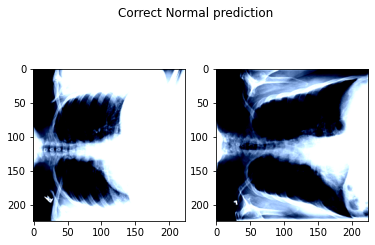

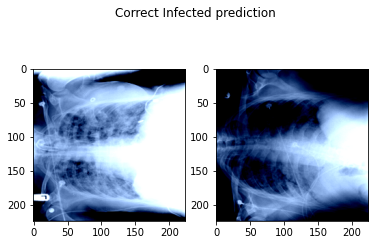

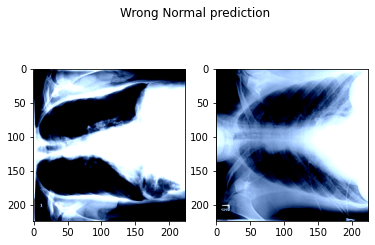

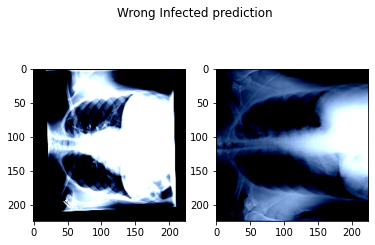

In [45]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = vgg16,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9),
               model_name_to_save = 'vgg16_FC_Only',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

VGG16 Model Training Started 


Train Epoch: 0 [8697/10717 (100%)]	Loss: 0.782217: : 670it [04:00,  2.78it/s]


	 	 Accuracy Training images: 87.3 %
	 	 Accuracy Validation images: 84.5 %


Train Epoch: 1 [8697/10717 (100%)]	Loss: 0.453714: : 670it [04:00,  2.78it/s]


	 	 Accuracy Training images: 87.4 %
	 	 Accuracy Validation images: 84.8 %


Train Epoch: 2 [8697/10717 (100%)]	Loss: 0.209659: : 670it [04:04,  2.74it/s]


	 	 Accuracy Training images: 87.7 %
	 	 Accuracy Validation images: 84.7 %


Train Epoch: 3 [8697/10717 (100%)]	Loss: 0.543193: : 670it [03:49,  2.92it/s]


	 	 Accuracy Training images: 87.5 %
	 	 Accuracy Validation images: 83.8 %


Train Epoch: 4 [8697/10717 (100%)]	Loss: 0.342159: : 670it [03:49,  2.92it/s]


	 	 Accuracy Training images: 87.7 %
	 	 Accuracy Validation images: 84.1 %


Train Epoch: 5 [8697/10717 (100%)]	Loss: 0.571018: : 670it [03:44,  2.98it/s]


	 	 Accuracy Training images: 88.3 %
	 	 Accuracy Validation images: 84.9 %


Train Epoch: 6 [8697/10717 (100%)]	Loss: 0.431692: : 670it [03:39,  3.05it/s]


	 	 Accuracy Training images: 88.1 %
	 	 Accuracy Validation images: 85.5 %


Train Epoch: 7 [8697/10717 (100%)]	Loss: 0.217212: : 670it [03:34,  3.12it/s]


	 	 Accuracy Training images: 88.0 %
	 	 Accuracy Validation images: 86.2 %


Train Epoch: 8 [8697/10717 (100%)]	Loss: 0.216773: : 670it [03:33,  3.14it/s]


	 	 Accuracy Training images: 88.0 %
	 	 Accuracy Validation images: 85.5 %


Train Epoch: 9 [8697/10717 (100%)]	Loss: 0.107503: : 670it [03:33,  3.13it/s]


	 	 Accuracy Training images: 87.9 %
	 	 Accuracy Validation images: 85.2 %


  0%|          | 0/94 [00:00<?, ?it/s]

Finished Training

  Test Accuracy : 


  0%|          | 0/670 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 93.2 %

  Confusion Matrices :


100%|██████████| 670/670 [03:28<00:00,  3.21it/s]


Predicted Infected  Predicted Normal
Actual Infected                4185               734
Actual Normal                   498              5300

100%|██████████| 94/94 [00:28<00:00,  3.27it/s]


Predicted Infected  Predicted Normal
Actual Infected                 518                97
Actual Normal                   109               776

100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Predicted Infected  Predicted Normal
Actual Infected                 544                71
Actual Normal                    25               860

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:25<00:00,  3.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [1 2]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [0 5]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [ 11 187]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [44 54]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


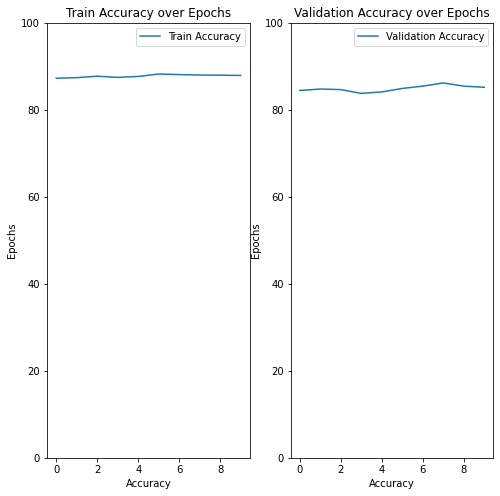

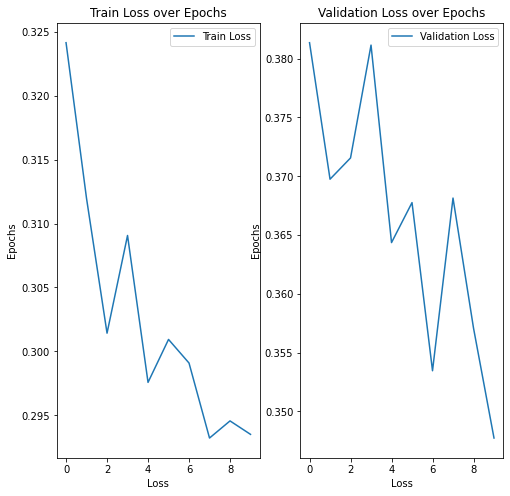

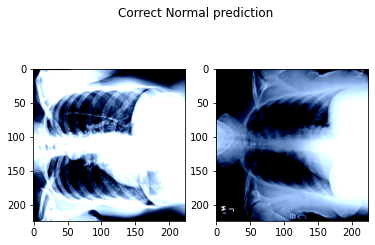

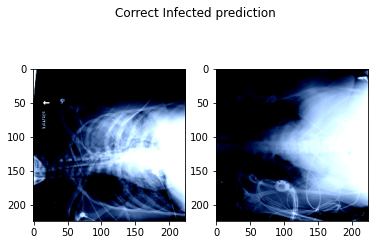

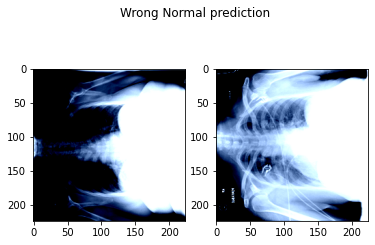

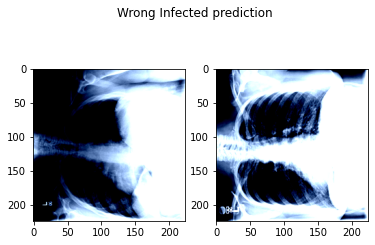

In [25]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = vgg16,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(vgg16.parameters(), lr=0.00001, momentum=0.9),
               model_name_to_save = 'vgg16_FC_Only_lr0.00001',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

In [37]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Freeze training for all features_layers
for param in vgg16.features.parameters():
    param.requires_grad = False

num_features = 2000
features = list(vgg16.classifier.children())[:4] # Remove  layers except first one with activation layer
features[0].out_features =num_features
features[0].in_features =(25088,4096) # the dimension of input tensor to first FCL is   7x7x512x4096 = (25088, 4096)
features[-1].out_features =2
features[-1].in_features =num_features # the dimension of input tensor to first FCL is   7x7x512x4096 = (25088, 4096)

vgg16.classifier = nn.Sequential(*features)
print(vgg16)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG16 Model Training Started 


Train Epoch: 0 [8697/10717 (100%)]	Loss: 0.553309: : 670it [03:35,  3.11it/s]


	 	 Accuracy Training images: 83.1 %
	 	 Accuracy Validation images: 82.4 %


Train Epoch: 1 [8697/10717 (100%)]	Loss: 0.499785: : 670it [03:33,  3.14it/s]


	 	 Accuracy Training images: 83.3 %
	 	 Accuracy Validation images: 78.3 %


Train Epoch: 2 [8697/10717 (100%)]	Loss: 0.447560: : 670it [03:42,  3.01it/s]


	 	 Accuracy Training images: 78.8 %
	 	 Accuracy Validation images: 75.9 %


Train Epoch: 3 [8697/10717 (100%)]	Loss: 0.668550: : 670it [03:38,  3.07it/s]


	 	 Accuracy Training images: 81.6 %
	 	 Accuracy Validation images: 81.2 %


Train Epoch: 4 [8697/10717 (100%)]	Loss: 0.102950: : 670it [03:33,  3.13it/s]


	 	 Accuracy Training images: 87.1 %
	 	 Accuracy Validation images: 83.8 %


Train Epoch: 5 [8697/10717 (100%)]	Loss: 0.118115: : 670it [03:33,  3.13it/s]


	 	 Accuracy Training images: 86.6 %
	 	 Accuracy Validation images: 84.0 %


Train Epoch: 6 [8697/10717 (100%)]	Loss: 0.129083: : 670it [03:33,  3.14it/s]


	 	 Accuracy Training images: 86.3 %
	 	 Accuracy Validation images: 82.9 %


Train Epoch: 7 [8697/10717 (100%)]	Loss: 0.199891: : 670it [03:33,  3.14it/s]


	 	 Accuracy Training images: 86.8 %
	 	 Accuracy Validation images: 83.4 %


Train Epoch: 8 [8697/10717 (100%)]	Loss: 0.433537: : 670it [03:33,  3.15it/s]


	 	 Accuracy Training images: 86.5 %
	 	 Accuracy Validation images: 85.0 %


Train Epoch: 9 [8697/10717 (100%)]	Loss: 0.395908: : 670it [03:33,  3.14it/s]


	 	 Accuracy Training images: 86.0 %
	 	 Accuracy Validation images: 82.5 %
Finished Training


  0%|          | 0/94 [00:00<?, ?it/s]


  Test Accuracy : 


  0%|          | 0/670 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 92.5 %

  Confusion Matrices :


100%|██████████| 670/670 [03:37<00:00,  3.08it/s]


Predicted Infected  Predicted Normal
Actual Infected                4339               580
Actual Normal                   942              4856

100%|██████████| 94/94 [00:30<00:00,  3.05it/s]


Predicted Infected  Predicted Normal
Actual Infected                 538                77
Actual Normal                   177               708

100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Predicted Infected  Predicted Normal
Actual Infected                 565                50
Actual Normal                    48               837

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [1 4]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [0 2]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [ 9 25]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [30 57]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


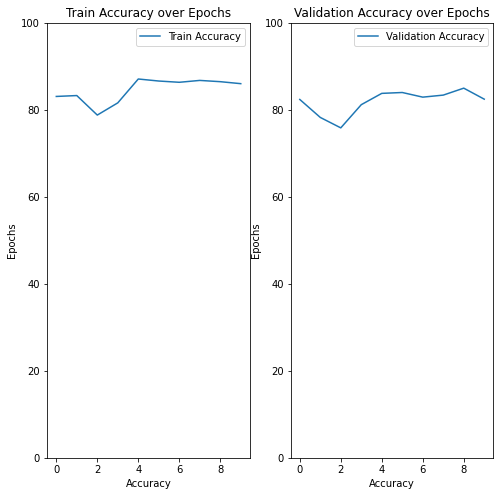

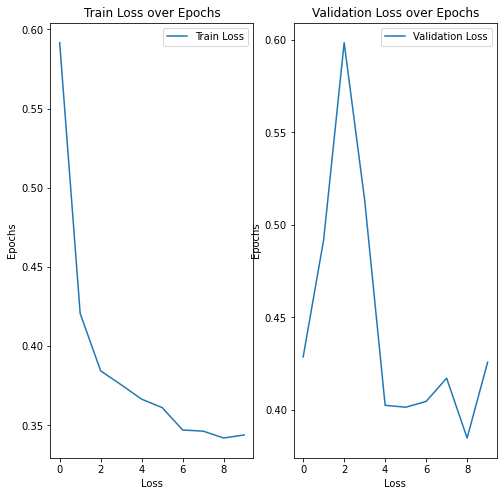

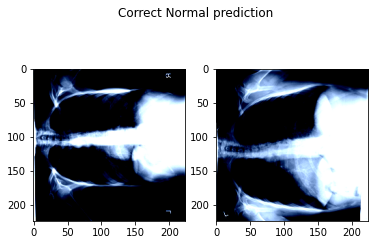

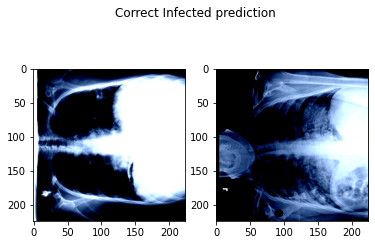

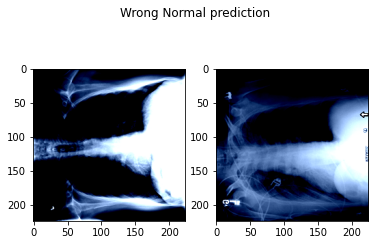

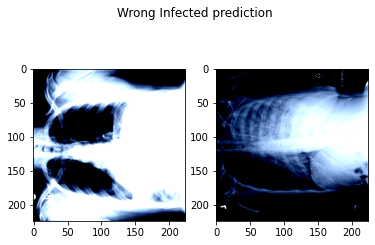

In [27]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = vgg16,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9),
               model_name_to_save = 'vgg16_FC_Only_2000',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

In [38]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Freeze training for all features_layers
for param in vgg16.features.parameters():
    param.requires_grad = False

num_features = 2000
features = list(vgg16.classifier.children())[:4] # Remove  layers except first one with activation layer
features[0].out_features =num_features
features[0].in_features =(25088,4096) # the dimension of input tensor to first FCL is   7x7x512x4096 = (25088, 4096)
features[-1].out_features =2
features[-1].in_features =num_features # the dimension of input tensor to first FCL is   7x7x512x4096 = (25088, 4096)

vgg16.classifier = nn.Sequential(*features)
print(vgg16)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG16 Model Training Started 


Train Epoch: 0 [7876/11467 (100%)]	Loss: 0.609021: : 717it [01:58,  6.08it/s]


	 	 Accuracy Training images: 75.4 %
	 	 Accuracy Validation images: 74.8 %


Train Epoch: 1 [7876/11467 (100%)]	Loss: 0.347675: : 717it [01:55,  6.19it/s]


	 	 Accuracy Training images: 79.0 %
	 	 Accuracy Validation images: 78.1 %


Train Epoch: 2 [7876/11467 (100%)]	Loss: 0.153428: : 717it [01:55,  6.21it/s]


	 	 Accuracy Training images: 80.3 %
	 	 Accuracy Validation images: 77.7 %


Train Epoch: 3 [7876/11467 (100%)]	Loss: 0.585786: : 717it [02:01,  5.91it/s]


	 	 Accuracy Training images: 80.8 %
	 	 Accuracy Validation images: 79.3 %


Train Epoch: 4 [7876/11467 (100%)]	Loss: 0.560684: : 717it [01:58,  6.07it/s]


	 	 Accuracy Training images: 81.8 %
	 	 Accuracy Validation images: 80.5 %


Train Epoch: 5 [7876/11467 (100%)]	Loss: 0.321886: : 717it [01:58,  6.06it/s]


	 	 Accuracy Training images: 82.2 %
	 	 Accuracy Validation images: 80.1 %


Train Epoch: 6 [7876/11467 (100%)]	Loss: 0.763104: : 717it [01:57,  6.09it/s]


	 	 Accuracy Training images: 82.8 %
	 	 Accuracy Validation images: 81.3 %


Train Epoch: 7 [7876/11467 (100%)]	Loss: 0.306812: : 717it [01:57,  6.10it/s]


	 	 Accuracy Training images: 83.1 %
	 	 Accuracy Validation images: 80.1 %


Train Epoch: 8 [7876/11467 (100%)]	Loss: 0.313219: : 717it [01:58,  6.05it/s]


	 	 Accuracy Training images: 83.0 %
	 	 Accuracy Validation images: 79.7 %


Train Epoch: 9 [7876/11467 (100%)]	Loss: 0.528740: : 717it [01:58,  6.06it/s]


	 	 Accuracy Training images: 83.7 %
	 	 Accuracy Validation images: 81.9 %


  0%|          | 0/94 [00:00<?, ?it/s]

Finished Training

  Test Accuracy : 


  0%|          | 0/717 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 90.1 %

  Confusion Matrices :


100%|██████████| 717/717 [01:55<00:00,  6.23it/s]


Predicted Infected  Predicted Normal
Actual Infected                3793              1126
Actual Normal                   694              5854

100%|██████████| 94/94 [00:15<00:00,  6.25it/s]


Predicted Infected  Predicted Normal
Actual Infected                 481               134
Actual Normal                   116               769

100%|██████████| 94/94 [00:13<00:00,  6.93it/s]


Predicted Infected  Predicted Normal
Actual Infected                 517                98
Actual Normal                    37               848

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:13<00:00,  6.74it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [0 3]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [1 2]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [57 95]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [16 32]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


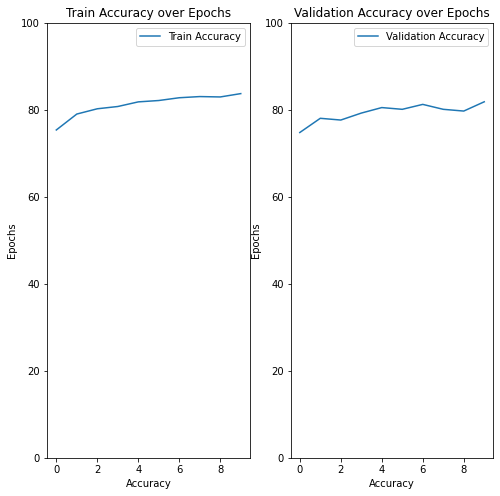

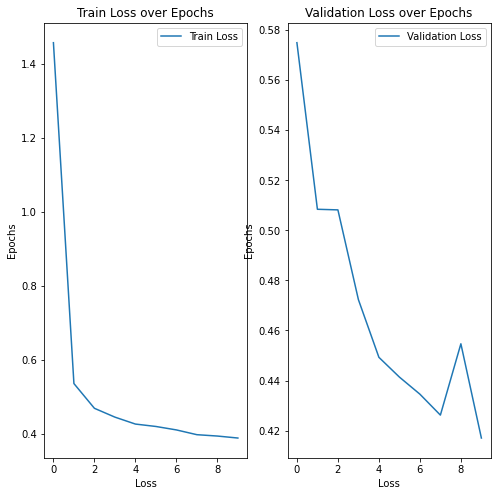

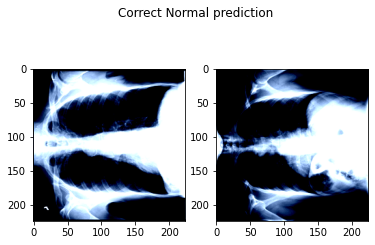

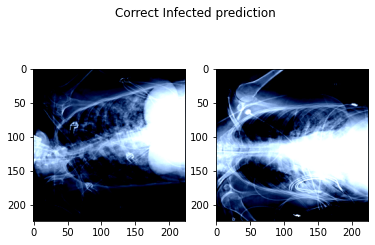

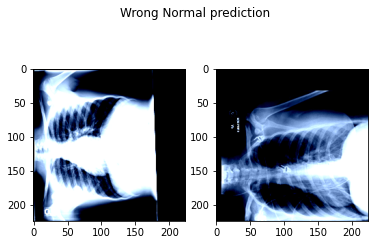

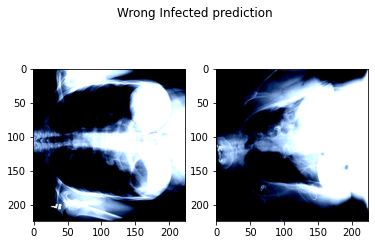

In [39]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = vgg16,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(vgg16.parameters(), lr=0.00001, momentum=0.9),
               model_name_to_save = 'vgg16_FC_Only_2000',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

### RESNET 18 

In [21]:
res18 = models.resnet18(pretrained=True)

# Freeze training for all layers

all_layers = list(res18.children())
for layer in all_layers:
    for param in layer.parameters():
        param.requires_grad = False

# Changing FCL 

num_features = (43 *10) + 100
features = nn.Sequential(nn.Linear(512, num_features),
                         nn.ReLU(),
                         nn.Linear(num_features, 2)
                         )
res18.fc =  features
print(res18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

RES18 Model Training Started 


Train Epoch: 0 [8244/11004 (100%)]	Loss: 0.434723: : 688it [04:00,  2.86it/s]


	 	 Accuracy Training images: 82.7 %
	 	 Accuracy Validation images: 79.0 %


Train Epoch: 1 [8244/11004 (100%)]	Loss: 0.315745: : 688it [04:00,  2.86it/s]


	 	 Accuracy Training images: 81.9 %
	 	 Accuracy Validation images: 78.9 %


Train Epoch: 2 [8244/11004 (100%)]	Loss: 0.428095: : 688it [04:04,  2.82it/s]


	 	 Accuracy Training images: 83.3 %
	 	 Accuracy Validation images: 81.5 %


Train Epoch: 3 [8244/11004 (100%)]	Loss: 0.291149: : 688it [04:00,  2.86it/s]


	 	 Accuracy Training images: 84.7 %
	 	 Accuracy Validation images: 82.3 %


Train Epoch: 4 [8244/11004 (100%)]	Loss: 0.312448: : 688it [04:01,  2.85it/s]


	 	 Accuracy Training images: 83.9 %
	 	 Accuracy Validation images: 81.3 %


Train Epoch: 5 [8244/11004 (100%)]	Loss: 0.333852: : 688it [04:01,  2.85it/s]


	 	 Accuracy Training images: 84.7 %
	 	 Accuracy Validation images: 83.2 %


Train Epoch: 6 [8244/11004 (100%)]	Loss: 0.494886: : 688it [04:00,  2.86it/s]


	 	 Accuracy Training images: 84.6 %
	 	 Accuracy Validation images: 83.0 %


Train Epoch: 7 [8244/11004 (100%)]	Loss: 0.132889: : 688it [04:00,  2.86it/s]


	 	 Accuracy Training images: 85.3 %
	 	 Accuracy Validation images: 83.4 %


Train Epoch: 8 [8244/11004 (100%)]	Loss: 0.380707: : 688it [04:01,  2.85it/s]


	 	 Accuracy Training images: 85.3 %
	 	 Accuracy Validation images: 82.1 %


Train Epoch: 9 [8244/11004 (100%)]	Loss: 0.587701: : 688it [04:05,  2.80it/s]


	 	 Accuracy Training images: 85.0 %
	 	 Accuracy Validation images: 81.8 %
Finished Training


  0%|          | 0/94 [00:00<?, ?it/s]


  Test Accuracy : 


  0%|          | 0/688 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 85.1 %

  Confusion Matrices :


100%|██████████| 688/688 [03:57<00:00,  2.90it/s]


Predicted Infected  Predicted Normal
Actual Infected                4149               770
Actual Normal                   897              5188

100%|██████████| 94/94 [00:31<00:00,  2.97it/s]


Predicted Infected  Predicted Normal
Actual Infected                 528                87
Actual Normal                   172               713

100%|██████████| 94/94 [00:30<00:00,  3.05it/s]


Predicted Infected  Predicted Normal
Actual Infected                 562                53
Actual Normal                   171               714

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:30<00:00,  3.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [0 3]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [1 2]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [18 23]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [15 50]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


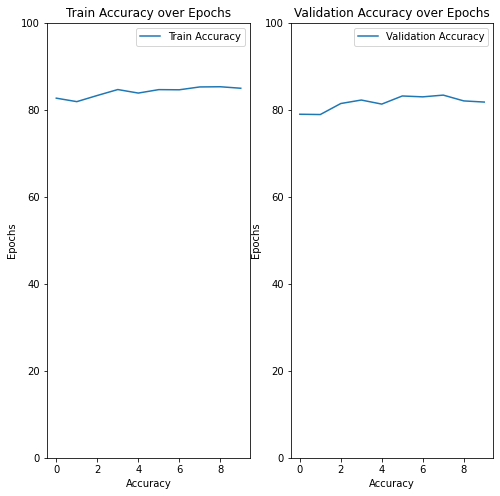

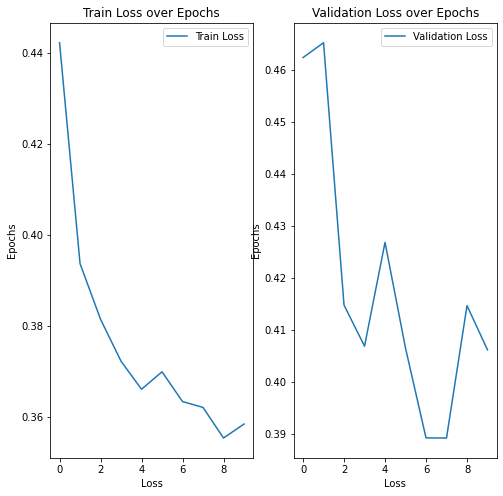

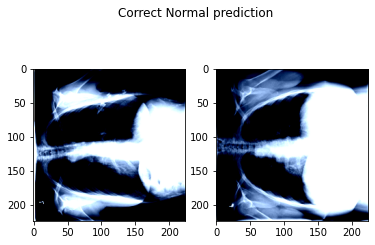

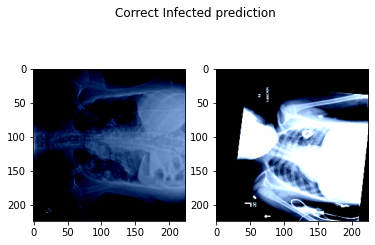

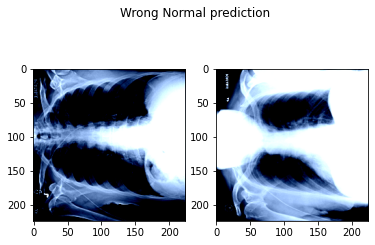

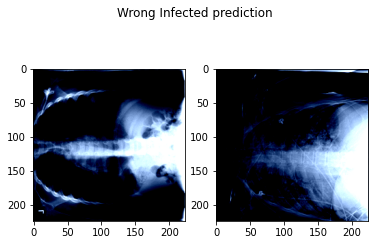

In [22]:
model_uc = res18

print( 'RES18 Model Training Started ')
model_training(model_loaded = res18,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=0.001, momentum=0.9),
               model_name_to_save = 'res18_FC_Only',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

RES18 Model Training Started 


Train Epoch: 0 [8244/11004 (100%)]	Loss: 0.254226: : 688it [03:58,  2.88it/s]


	 	 Accuracy Training images: 85.8 %
	 	 Accuracy Validation images: 83.6 %


Train Epoch: 1 [8244/11004 (100%)]	Loss: 0.244127: : 688it [03:54,  2.93it/s]


	 	 Accuracy Training images: 85.1 %
	 	 Accuracy Validation images: 84.3 %


Train Epoch: 2 [8244/11004 (100%)]	Loss: 0.258564: : 688it [03:56,  2.91it/s]


	 	 Accuracy Training images: 85.9 %
	 	 Accuracy Validation images: 83.5 %


Train Epoch: 3 [8244/11004 (100%)]	Loss: 0.305257: : 688it [03:57,  2.90it/s]


	 	 Accuracy Training images: 85.8 %
	 	 Accuracy Validation images: 83.2 %


Train Epoch: 4 [8244/11004 (100%)]	Loss: 0.209293: : 688it [03:59,  2.87it/s]


	 	 Accuracy Training images: 85.8 %
	 	 Accuracy Validation images: 83.0 %


Train Epoch: 5 [8244/11004 (100%)]	Loss: 0.393683: : 688it [03:59,  2.87it/s]


	 	 Accuracy Training images: 85.5 %
	 	 Accuracy Validation images: 83.5 %


Train Epoch: 6 [8244/11004 (100%)]	Loss: 0.260969: : 688it [04:01,  2.85it/s]


	 	 Accuracy Training images: 85.3 %
	 	 Accuracy Validation images: 81.9 %


Train Epoch: 7 [8244/11004 (100%)]	Loss: 0.269684: : 688it [03:56,  2.91it/s]


	 	 Accuracy Training images: 85.7 %
	 	 Accuracy Validation images: 82.3 %


Train Epoch: 8 [8244/11004 (100%)]	Loss: 0.295582: : 688it [03:58,  2.89it/s]


	 	 Accuracy Training images: 85.3 %
	 	 Accuracy Validation images: 84.1 %


Train Epoch: 9 [8244/11004 (100%)]	Loss: 0.516483: : 688it [03:57,  2.90it/s]


	 	 Accuracy Training images: 85.8 %
	 	 Accuracy Validation images: 83.7 %
Finished Training


  0%|          | 0/94 [00:00<?, ?it/s]


  Test Accuracy : 


  0%|          | 0/688 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 88.0 %

  Confusion Matrices :


100%|██████████| 688/688 [03:57<00:00,  2.89it/s]


Predicted Infected  Predicted Normal
Actual Infected                3990               929
Actual Normal                   675              5410

100%|██████████| 94/94 [00:31<00:00,  2.96it/s]


Predicted Infected  Predicted Normal
Actual Infected                 486               129
Actual Normal                   129               756

100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Predicted Infected  Predicted Normal
Actual Infected                 539                76
Actual Normal                   121               764

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:30<00:00,  3.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [1 5]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [0 2]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Wrong Normal prediction indices [12 56]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [11 31]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


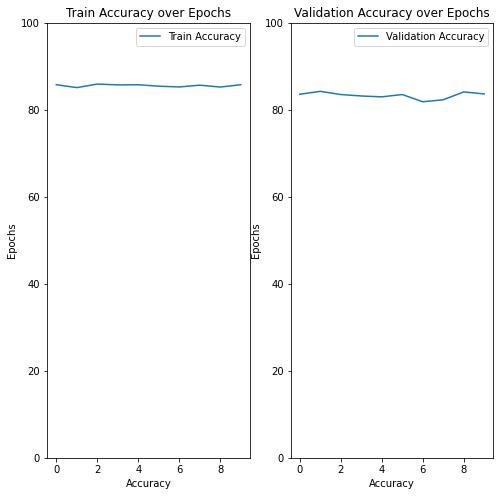

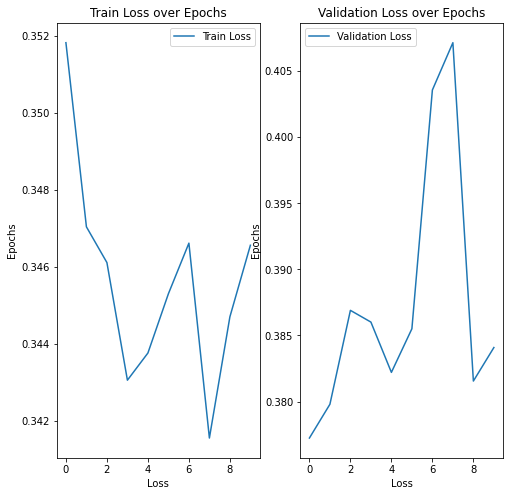

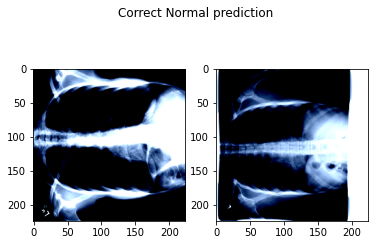

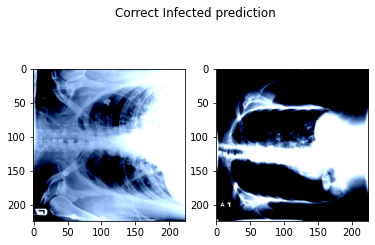

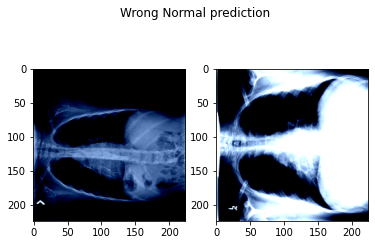

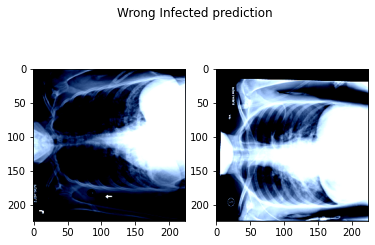

In [23]:
model_uc = res18

print( 'RES18 Model Training Started ')
model_training(model_loaded = res18,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=0.00001, momentum=0.9),
               model_name_to_save = 'res18_FC_Only',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

In [30]:
res18 = models.resnet18(pretrained=True)

# Freeze training for all layers

all_layers = list(res18.children())
for layer in all_layers:
    for param in layer.parameters():
        param.requires_grad = False

# Changing FCL 

num_features = 2000
features = nn.Sequential(nn.Linear(512, num_features),
                         nn.ReLU(),
                         nn.Linear(num_features, 2)
                         )
res18.fc =  features
print(res18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

RES18 Model Training Started 


Train Epoch: 0 [7876/11467 (100%)]	Loss: 0.522108: : 717it [01:50,  6.51it/s]


	 	 Accuracy Training images: 72.9 %
	 	 Accuracy Validation images: 72.8 %


Train Epoch: 1 [7876/11467 (100%)]	Loss: 0.538150: : 717it [01:51,  6.44it/s]


	 	 Accuracy Training images: 78.3 %
	 	 Accuracy Validation images: 73.3 %


Train Epoch: 2 [7876/11467 (100%)]	Loss: 0.544743: : 717it [01:52,  6.39it/s]


	 	 Accuracy Training images: 77.6 %
	 	 Accuracy Validation images: 75.7 %


Train Epoch: 3 [7876/11467 (100%)]	Loss: 0.476324: : 717it [01:52,  6.36it/s]


	 	 Accuracy Training images: 79.5 %
	 	 Accuracy Validation images: 76.6 %


Train Epoch: 4 [7876/11467 (100%)]	Loss: 0.437852: : 717it [01:49,  6.56it/s]


	 	 Accuracy Training images: 80.2 %
	 	 Accuracy Validation images: 78.6 %


Train Epoch: 5 [7876/11467 (100%)]	Loss: 0.493513: : 717it [01:50,  6.47it/s]


	 	 Accuracy Training images: 80.1 %
	 	 Accuracy Validation images: 77.8 %


Train Epoch: 6 [7876/11467 (100%)]	Loss: 0.827007: : 717it [01:51,  6.41it/s]


	 	 Accuracy Training images: 80.9 %
	 	 Accuracy Validation images: 78.7 %


Train Epoch: 7 [7876/11467 (100%)]	Loss: 0.422320: : 717it [01:51,  6.42it/s]


	 	 Accuracy Training images: 81.0 %
	 	 Accuracy Validation images: 79.0 %


Train Epoch: 8 [7876/11467 (100%)]	Loss: 0.599586: : 717it [01:52,  6.35it/s]


	 	 Accuracy Training images: 81.7 %
	 	 Accuracy Validation images: 79.7 %


Train Epoch: 9 [7876/11467 (100%)]	Loss: 0.543065: : 717it [01:52,  6.35it/s]


	 	 Accuracy Training images: 81.1 %


  0%|          | 0/94 [00:00<?, ?it/s]

	 	 Accuracy Validation images: 78.9 %
Finished Training

  Test Accuracy : 


  0%|          | 0/717 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 85.1 %

  Confusion Matrices :


100%|██████████| 717/717 [01:51<00:00,  6.43it/s]


Predicted Infected  Predicted Normal
Actual Infected                3633              1286
Actual Normal                   830              5718

100%|██████████| 94/94 [00:14<00:00,  6.57it/s]


Predicted Infected  Predicted Normal
Actual Infected                 438               177
Actual Normal                   136               749

100%|██████████| 94/94 [00:12<00:00,  7.30it/s]


Predicted Infected  Predicted Normal
Actual Infected                 483               132
Actual Normal                    89               796

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:13<00:00,  7.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [1 2]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [0 3]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [5 9]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [13 23]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


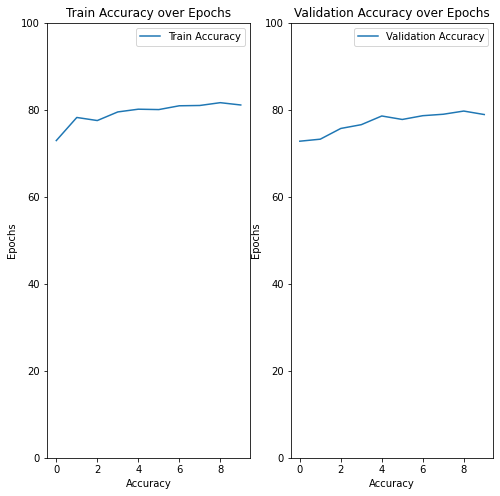

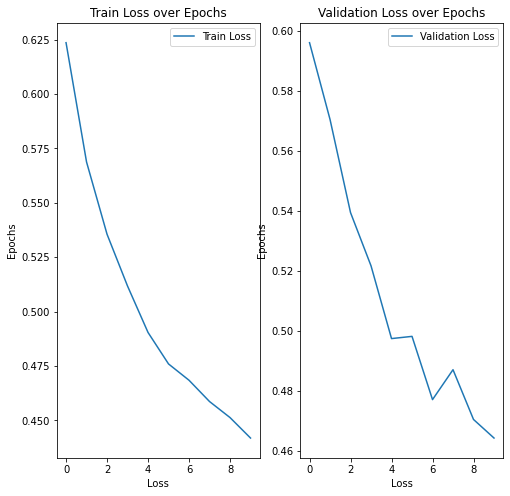

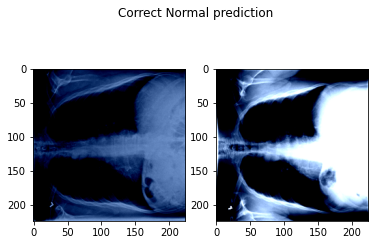

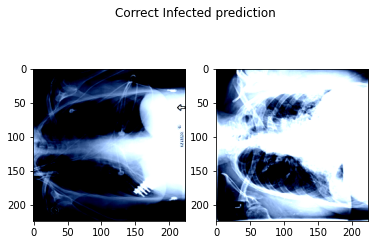

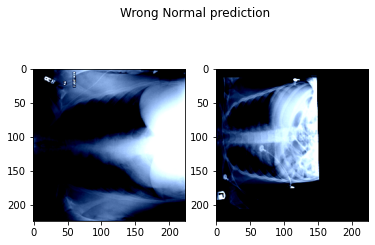

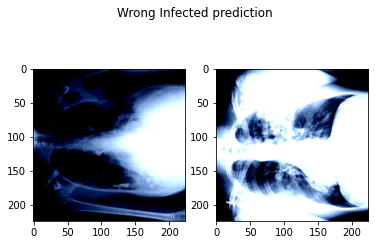

In [31]:
model_uc = res18

print( 'RES18 Model Training Started ')
model_training(model_loaded = res18,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=0.00001, momentum=0.9),
               model_name_to_save = 'res18_FC_Only_2000',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

**De allocation**

In [0]:

# del vgg16
# del res18

## TASK 2

### VGG 16

In [13]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

VGG16 Model Training Started 


Train Epoch: 0 [7876/11467 (100%)]	Loss: 0.487827: : 717it [10:16,  1.16it/s]


	 	 Accuracy Training images: 78.1 %
	 	 Accuracy Validation images: 75.1 %


Train Epoch: 1 [7876/11467 (100%)]	Loss: 0.489125: : 717it [02:08,  5.57it/s]


	 	 Accuracy Training images: 74.8 %
	 	 Accuracy Validation images: 70.7 %


Train Epoch: 2 [7876/11467 (100%)]	Loss: 0.193899: : 717it [02:07,  5.63it/s]


	 	 Accuracy Training images: 84.6 %
	 	 Accuracy Validation images: 83.3 %


Train Epoch: 3 [7876/11467 (100%)]	Loss: 0.263800: : 717it [02:07,  5.61it/s]


	 	 Accuracy Training images: 82.1 %
	 	 Accuracy Validation images: 78.3 %


Train Epoch: 4 [7876/11467 (100%)]	Loss: 0.121304: : 717it [02:08,  5.58it/s]


	 	 Accuracy Training images: 84.5 %
	 	 Accuracy Validation images: 82.3 %


Train Epoch: 5 [7876/11467 (100%)]	Loss: 0.165662: : 717it [02:07,  5.63it/s]


	 	 Accuracy Training images: 87.9 %
	 	 Accuracy Validation images: 86.5 %


Train Epoch: 6 [7876/11467 (100%)]	Loss: 0.266202: : 717it [02:06,  5.68it/s]


	 	 Accuracy Training images: 88.6 %
	 	 Accuracy Validation images: 84.5 %


Train Epoch: 7 [7876/11467 (100%)]	Loss: 0.359394: : 717it [02:06,  5.68it/s]


	 	 Accuracy Training images: 88.6 %
	 	 Accuracy Validation images: 85.6 %


Train Epoch: 8 [7876/11467 (100%)]	Loss: 0.249097: : 717it [02:07,  5.61it/s]


	 	 Accuracy Training images: 89.9 %
	 	 Accuracy Validation images: 87.3 %


Train Epoch: 9 [7876/11467 (100%)]	Loss: 0.225903: : 717it [02:06,  5.66it/s]


	 	 Accuracy Training images: 89.6 %
	 	 Accuracy Validation images: 86.1 %


  0%|          | 0/94 [00:00<?, ?it/s]

Finished Training

  Test Accuracy : 


  0%|          | 0/717 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 96.1 %

  Confusion Matrices :


100%|██████████| 717/717 [01:50<00:00,  6.51it/s]


Predicted Infected  Predicted Normal
Actual Infected                4347               572
Actual Normal                   610              5938

100%|██████████| 94/94 [00:14<00:00,  6.54it/s]


Predicted Infected  Predicted Normal
Actual Infected                 536                79
Actual Normal                   122               763

100%|██████████| 94/94 [00:12<00:00,  7.33it/s]


Predicted Infected  Predicted Normal
Actual Infected                 584                31
Actual Normal                    29               856

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:13<00:00,  7.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [1 4]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [0 2]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [  8 176]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [28 37]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


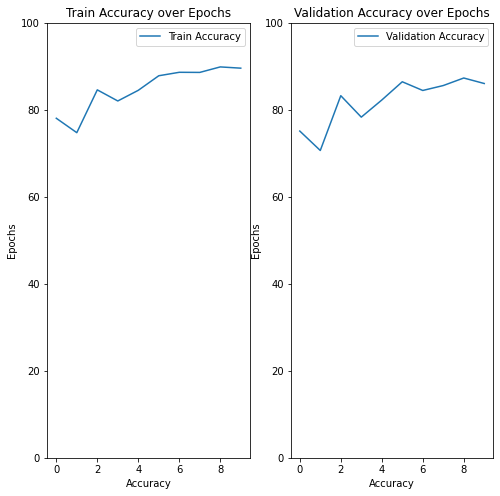

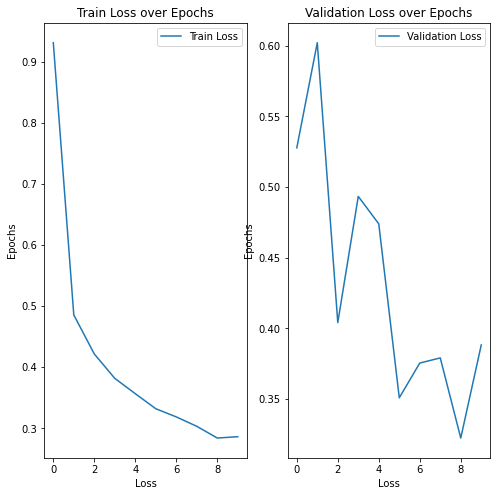

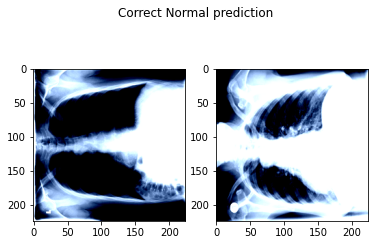

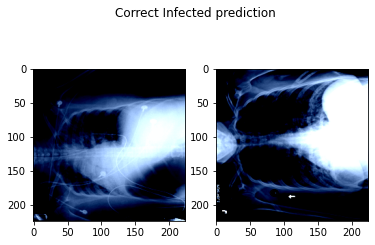

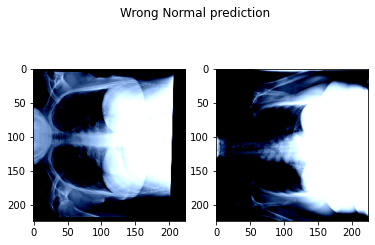

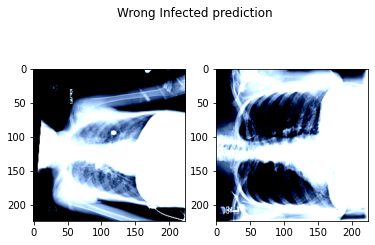

In [27]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = vgg16,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9),
               model_name_to_save = 'vgg16_entire',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

In [0]:
# Freeze training for all features_layers
for param in vgg16.features.parameters():
    param.requires_grad = False


VGG16 Model Training Started 


Train Epoch: 0 [7876/11467 (100%)]	Loss: 0.150721: : 717it [01:53,  6.32it/s]


	 	 Accuracy Training images: 90.3 %
	 	 Accuracy Validation images: 88.6 %


Train Epoch: 1 [7876/11467 (100%)]	Loss: 0.481963: : 717it [01:54,  6.28it/s]


	 	 Accuracy Training images: 90.2 %
	 	 Accuracy Validation images: 87.4 %


Train Epoch: 2 [7876/11467 (100%)]	Loss: 0.340052: : 717it [01:56,  6.13it/s]


	 	 Accuracy Training images: 90.2 %
	 	 Accuracy Validation images: 87.3 %


Train Epoch: 3 [7876/11467 (100%)]	Loss: 0.476799: : 717it [01:55,  6.21it/s]


	 	 Accuracy Training images: 90.7 %
	 	 Accuracy Validation images: 87.1 %


Train Epoch: 4 [7876/11467 (100%)]	Loss: 0.211835: : 717it [01:54,  6.26it/s]


	 	 Accuracy Training images: 90.0 %
	 	 Accuracy Validation images: 87.0 %


Train Epoch: 5 [7876/11467 (100%)]	Loss: 0.061842: : 717it [01:54,  6.24it/s]


	 	 Accuracy Training images: 90.5 %
	 	 Accuracy Validation images: 87.7 %


Train Epoch: 6 [7876/11467 (100%)]	Loss: 0.646435: : 717it [01:55,  6.20it/s]


	 	 Accuracy Training images: 90.1 %
	 	 Accuracy Validation images: 87.4 %


Train Epoch: 7 [7876/11467 (100%)]	Loss: 0.316639: : 717it [01:55,  6.20it/s]


	 	 Accuracy Training images: 90.1 %
	 	 Accuracy Validation images: 86.8 %


Train Epoch: 8 [7876/11467 (100%)]	Loss: 0.324721: : 717it [01:55,  6.20it/s]


	 	 Accuracy Training images: 90.3 %
	 	 Accuracy Validation images: 87.1 %


Train Epoch: 9 [7876/11467 (100%)]	Loss: 0.102828: : 717it [01:55,  6.21it/s]


	 	 Accuracy Training images: 90.4 %
	 	 Accuracy Validation images: 86.7 %


  0%|          | 0/94 [00:00<?, ?it/s]

Finished Training

  Test Accuracy : 


  0%|          | 0/717 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 96.3 %

  Confusion Matrices :


100%|██████████| 717/717 [01:51<00:00,  6.41it/s]


Predicted Infected  Predicted Normal
Actual Infected                4173               746
Actual Normal                   376              6172

100%|██████████| 94/94 [00:14<00:00,  6.50it/s]


Predicted Infected  Predicted Normal
Actual Infected                 518                97
Actual Normal                    74               811

100%|██████████| 94/94 [00:13<00:00,  7.12it/s]


Predicted Infected  Predicted Normal
Actual Infected                 573                42
Actual Normal                     9               876

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:13<00:00,  7.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [0 2]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [1 3]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [127 151]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [49 80]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


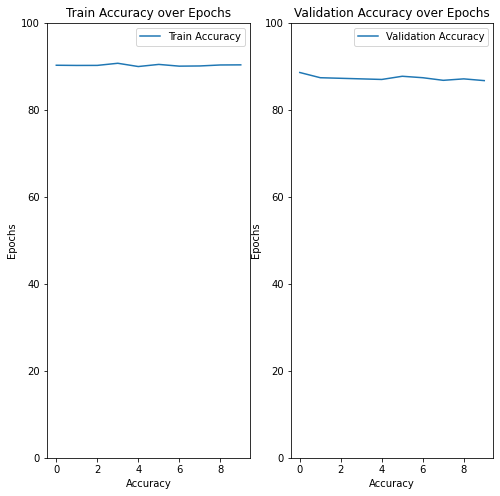

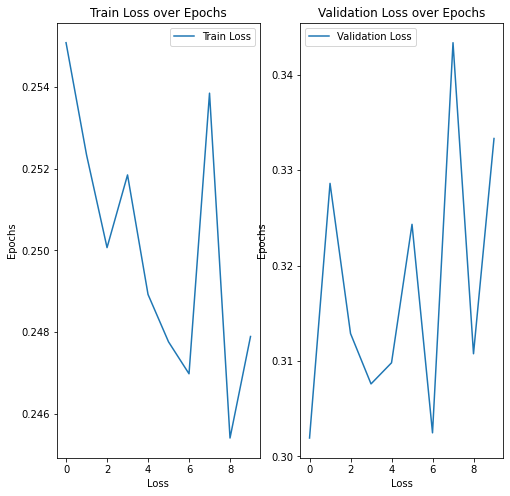

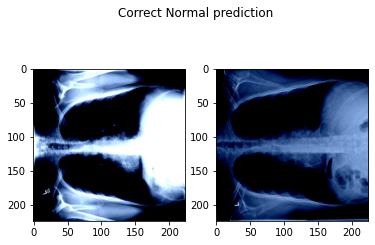

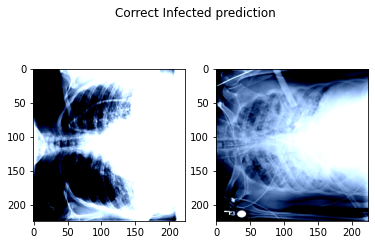

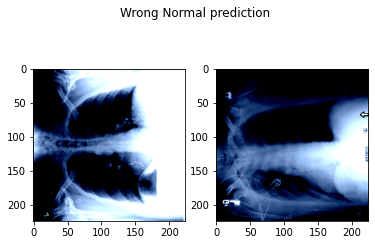

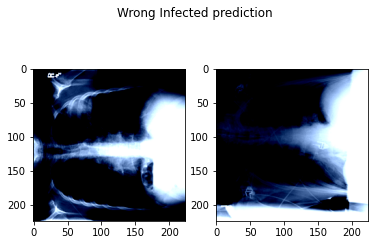

In [29]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = vgg16,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9),
               model_name_to_save = 'vgg16_task2_FC_only',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
to_freeze = [0,2,5,10,24,28]
for layer_no in to_freeze:
  for param in vgg16.features[layer_no].parameters():
    param.requires_grad = False


VGG16 Model Training Started 


Train Epoch: 0 [7876/11467 (100%)]	Loss: 0.454139: : 717it [02:04,  5.76it/s]


	 	 Accuracy Training images: 88.4 %
	 	 Accuracy Validation images: 86.1 %


Train Epoch: 1 [7876/11467 (100%)]	Loss: 0.395032: : 717it [02:04,  5.77it/s]


	 	 Accuracy Training images: 89.7 %
	 	 Accuracy Validation images: 87.0 %


Train Epoch: 2 [7876/11467 (100%)]	Loss: 0.115178: : 717it [02:04,  5.76it/s]


	 	 Accuracy Training images: 91.4 %
	 	 Accuracy Validation images: 89.5 %


Train Epoch: 3 [7876/11467 (100%)]	Loss: 0.128633: : 717it [02:04,  5.76it/s]


	 	 Accuracy Training images: 89.4 %
	 	 Accuracy Validation images: 84.3 %


Train Epoch: 4 [7876/11467 (100%)]	Loss: 0.534887: : 717it [02:06,  5.68it/s]


	 	 Accuracy Training images: 91.8 %
	 	 Accuracy Validation images: 88.7 %


Train Epoch: 5 [7876/11467 (100%)]	Loss: 0.338750: : 717it [02:07,  5.63it/s]


	 	 Accuracy Training images: 92.1 %
	 	 Accuracy Validation images: 89.1 %


Train Epoch: 6 [7876/11467 (100%)]	Loss: 0.031781: : 717it [02:06,  5.69it/s]


	 	 Accuracy Training images: 92.3 %
	 	 Accuracy Validation images: 89.1 %


Train Epoch: 7 [7876/11467 (100%)]	Loss: 0.169813: : 717it [02:06,  5.65it/s]


	 	 Accuracy Training images: 92.1 %
	 	 Accuracy Validation images: 88.9 %


Train Epoch: 8 [7876/11467 (100%)]	Loss: 0.043967: : 717it [02:07,  5.62it/s]


	 	 Accuracy Training images: 89.7 %
	 	 Accuracy Validation images: 87.1 %


Train Epoch: 9 [7876/11467 (100%)]	Loss: 0.137734: : 717it [02:07,  5.61it/s]


	 	 Accuracy Training images: 92.2 %
	 	 Accuracy Validation images: 88.8 %


  0%|          | 0/94 [00:00<?, ?it/s]

Finished Training

  Test Accuracy : 


  0%|          | 0/717 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 97.3 %

  Confusion Matrices :


100%|██████████| 717/717 [01:57<00:00,  6.10it/s]


Predicted Infected  Predicted Normal
Actual Infected                4510               409
Actual Normal                   503              6045

100%|██████████| 94/94 [00:15<00:00,  6.24it/s]


Predicted Infected  Predicted Normal
Actual Infected                 561                54
Actual Normal                    95               790

100%|██████████| 94/94 [00:13<00:00,  6.79it/s]


Predicted Infected  Predicted Normal
Actual Infected                 589                26
Actual Normal                    17               868

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:13<00:00,  6.75it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [1 5]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [0 2]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [49 50]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [24 60]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


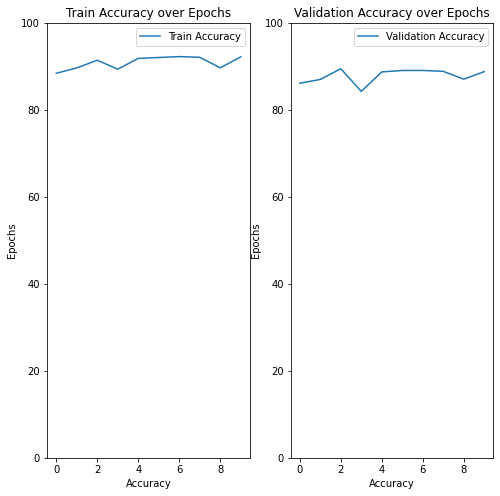

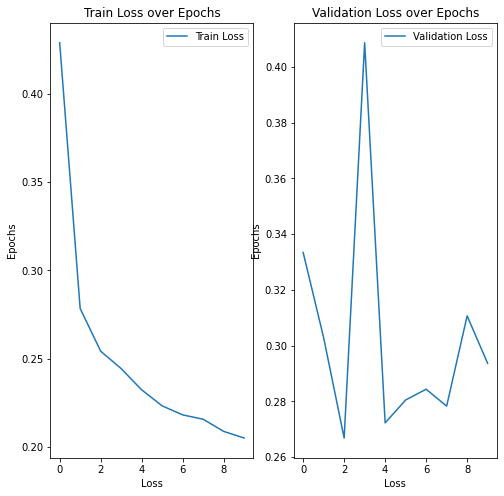

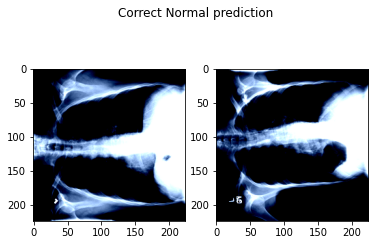

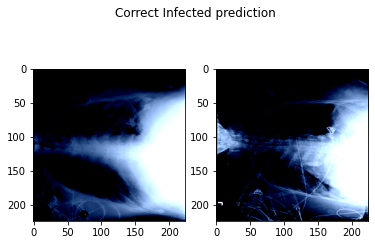

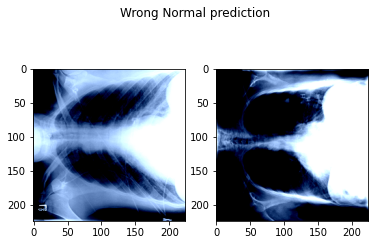

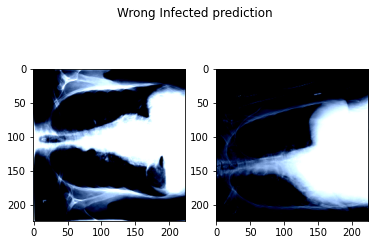

In [33]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = vgg16,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9),
               model_name_to_save = 'vgg16_task2_FC_only',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

### RESNET 18

In [0]:
res18 = models.resnet18(pretrained=True)

RESNET18 Model Training Started 


Train Epoch: 0 [7876/11467 (100%)]	Loss: 0.079087: : 717it [03:52,  3.08it/s]


	 	 Accuracy Training images: 87.7 %
	 	 Accuracy Validation images: 86.3 %


Train Epoch: 1 [7876/11467 (100%)]	Loss: 0.738175: : 717it [03:45,  3.17it/s]


	 	 Accuracy Training images: 86.1 %
	 	 Accuracy Validation images: 83.1 %


Train Epoch: 2 [7876/11467 (100%)]	Loss: 0.113466: : 717it [03:39,  3.27it/s]


	 	 Accuracy Training images: 89.2 %
	 	 Accuracy Validation images: 85.4 %


Train Epoch: 3 [7876/11467 (100%)]	Loss: 0.319085: : 717it [03:39,  3.26it/s]


	 	 Accuracy Training images: 89.6 %
	 	 Accuracy Validation images: 87.7 %


Train Epoch: 4 [7876/11467 (100%)]	Loss: 0.078296: : 717it [03:45,  3.18it/s]


	 	 Accuracy Training images: 90.0 %
	 	 Accuracy Validation images: 85.1 %


Train Epoch: 5 [7876/11467 (100%)]	Loss: 0.323507: : 717it [03:46,  3.17it/s]


	 	 Accuracy Training images: 90.8 %
	 	 Accuracy Validation images: 88.5 %


Train Epoch: 6 [7876/11467 (100%)]	Loss: 0.355930: : 717it [03:47,  3.15it/s]


	 	 Accuracy Training images: 91.3 %
	 	 Accuracy Validation images: 88.1 %


Train Epoch: 7 [7876/11467 (100%)]	Loss: 0.249007: : 717it [03:43,  3.21it/s]


	 	 Accuracy Training images: 91.5 %
	 	 Accuracy Validation images: 87.9 %


Train Epoch: 8 [7876/11467 (100%)]	Loss: 0.058427: : 717it [03:46,  3.16it/s]


	 	 Accuracy Training images: 91.6 %
	 	 Accuracy Validation images: 87.3 %


Train Epoch: 9 [7876/11467 (100%)]	Loss: 0.302839: : 717it [03:41,  3.24it/s]


	 	 Accuracy Training images: 91.6 %
	 	 Accuracy Validation images: 87.9 %
Finished Training


  0%|          | 0/94 [00:00<?, ?it/s]


  Test Accuracy : 


  0%|          | 0/717 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 96.5 %

  Confusion Matrices :


100%|██████████| 717/717 [03:34<00:00,  3.35it/s]

False False
label [0 0 1 ... 0 0 1] 
predict [0 0 1 ... 1 0 1] 
cfm [[4453  466]
 [ 484 6064]]


Predicted Infected  Predicted Normal
Actual Infected                4453               466
Actual Normal                   484              6064

100%|██████████| 94/94 [00:27<00:00,  3.40it/s]

False False
label [1 0 1 ... 1 1 1] 
predict [1 0 1 ... 1 0 1] 
cfm [[552  63]
 [101 784]]


Predicted Infected  Predicted Normal
Actual Infected                 552                63
Actual Normal                   101               784

100%|██████████| 94/94 [00:24<00:00,  3.79it/s]

False False
label [0 0 0 ... 1 1 1] 
predict [0 0 0 ... 1 1 1] 
cfm [[595  20]
 [ 30 855]]


Predicted Infected  Predicted Normal
Actual Infected                 595                20
Actual Normal                    30               855

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [0 1]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [2 6]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [ 31 172]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [28 76]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


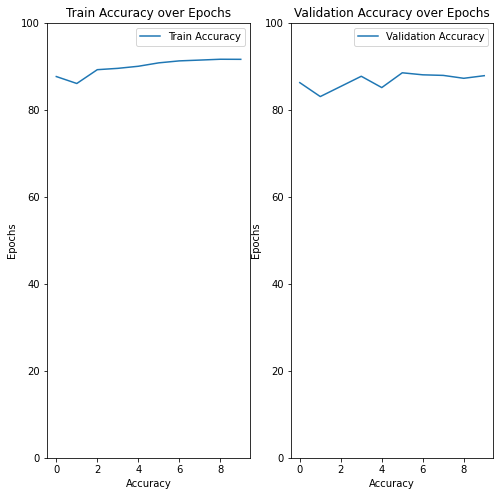

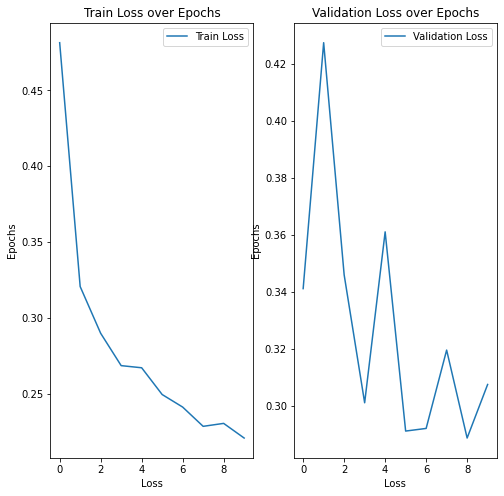

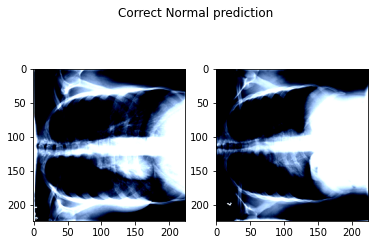

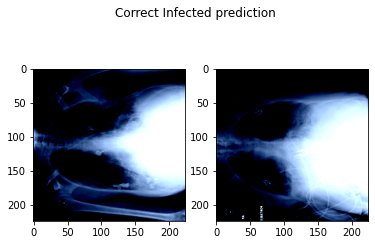

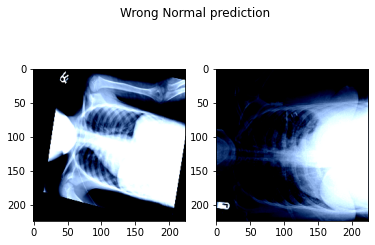

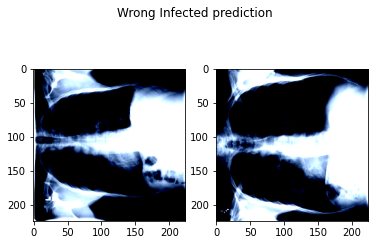

In [0]:
model_uc = res18

print( 'RESNET18 Model Training Started ')
model_training(model_loaded = res18,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=0.001, momentum=0.9),
               model_name_to_save = 'res18_entire',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

In [0]:
res18 = models.resnet18(pretrained=True)
for param in list(res18.children())[-1].parameters():
  param.requires_grad = False

RESNET18 Model Training Started 


Train Epoch: 0 [7876/11467 (100%)]	Loss: 0.438171: : 717it [03:42,  3.22it/s]


	 	 Accuracy Training images: 86.8 %
	 	 Accuracy Validation images: 83.8 %


Train Epoch: 1 [7876/11467 (100%)]	Loss: 0.596984: : 717it [03:41,  3.24it/s]


	 	 Accuracy Training images: 89.1 %
	 	 Accuracy Validation images: 86.7 %


Train Epoch: 2 [7876/11467 (100%)]	Loss: 0.231965: : 717it [03:45,  3.18it/s]


	 	 Accuracy Training images: 89.5 %
	 	 Accuracy Validation images: 86.5 %


Train Epoch: 3 [7876/11467 (100%)]	Loss: 1.096449: : 717it [03:42,  3.22it/s]


	 	 Accuracy Training images: 89.9 %
	 	 Accuracy Validation images: 87.0 %


Train Epoch: 4 [7876/11467 (100%)]	Loss: 0.050493: : 717it [03:41,  3.23it/s]


	 	 Accuracy Training images: 90.6 %
	 	 Accuracy Validation images: 86.9 %


Train Epoch: 5 [7876/11467 (100%)]	Loss: 0.049378: : 717it [03:44,  3.20it/s]


	 	 Accuracy Training images: 90.2 %
	 	 Accuracy Validation images: 88.1 %


Train Epoch: 6 [7876/11467 (100%)]	Loss: 0.477358: : 717it [03:41,  3.24it/s]


	 	 Accuracy Training images: 91.5 %
	 	 Accuracy Validation images: 89.3 %


Train Epoch: 7 [7876/11467 (100%)]	Loss: 0.305287: : 717it [03:43,  3.21it/s]


	 	 Accuracy Training images: 90.9 %
	 	 Accuracy Validation images: 88.7 %


Train Epoch: 8 [7876/11467 (100%)]	Loss: 0.391025: : 717it [03:46,  3.16it/s]


	 	 Accuracy Training images: 90.7 %
	 	 Accuracy Validation images: 87.4 %


Train Epoch: 9 [7876/11467 (100%)]	Loss: 0.124001: : 717it [03:48,  3.14it/s]


	 	 Accuracy Training images: 91.6 %
	 	 Accuracy Validation images: 89.4 %
Finished Training


  0%|          | 0/94 [00:00<?, ?it/s]


  Test Accuracy : 


  0%|          | 0/717 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 96.9 %

  Confusion Matrices :


100%|██████████| 717/717 [03:36<00:00,  3.31it/s]

False False
label [1 0 1 ... 1 1 0] 
predict [1 0 1 ... 1 1 0] 
cfm [[4181  738]
 [ 230 6318]]


Predicted Infected  Predicted Normal
Actual Infected                4181               738
Actual Normal                   230              6318

100%|██████████| 94/94 [00:27<00:00,  3.38it/s]

False False
label [1 1 0 ... 0 0 0] 
predict [1 1 0 ... 0 0 0] 
cfm [[495 120]
 [ 64 821]]


Predicted Infected  Predicted Normal
Actual Infected                 495               120
Actual Normal                    64               821

100%|██████████| 94/94 [00:24<00:00,  3.76it/s]

False False
label [1 1 1 ... 1 0 1] 
predict [1 1 1 ... 1 0 1] 
cfm [[581  34]
 [ 14 871]]


Predicted Infected  Predicted Normal
Actual Infected                 581                34
Actual Normal                    14               871

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [0 1]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [2 3]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Wrong Normal prediction indices [ 84 125]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [231 279]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


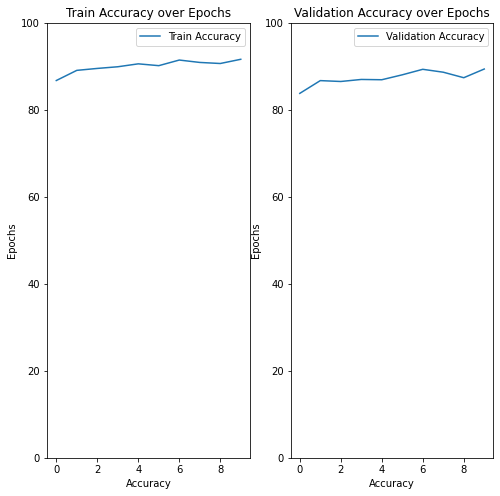

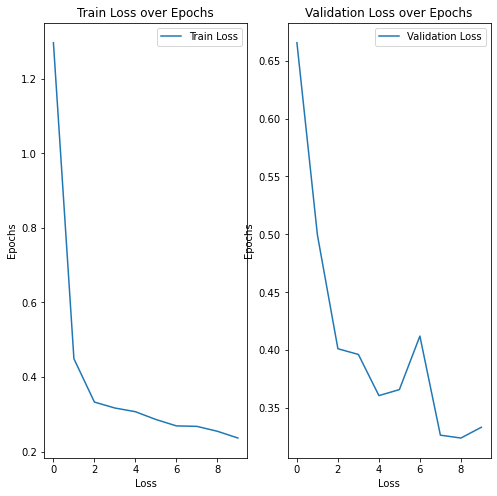

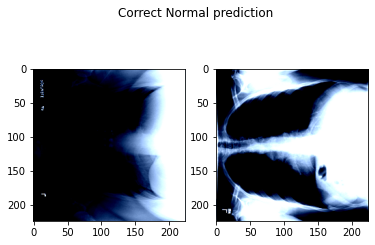

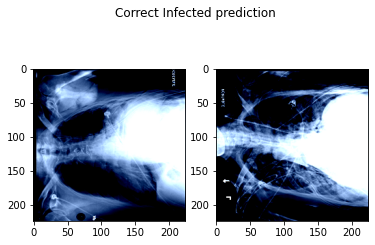

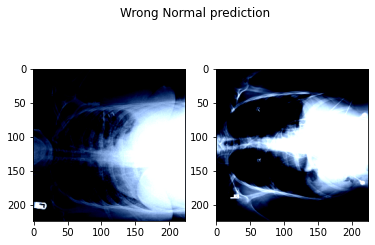

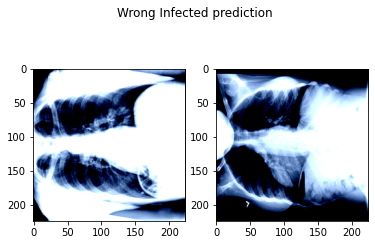

In [0]:
model_uc = res18

print( 'RESNET18 Model Training Started ')
model_training(model_loaded = res18,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=0.001, momentum=0.9),
               model_name_to_save = 'res18_entire_task2_FConly',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)

In [0]:
res18 = models.resnet18(pretrained=True)
for param in res18.layer1.parameters():
    param.requires_grad = False
for param in res18.layer2.parameters():
    param.requires_grad = False

RESNET18 Model Training Started 


Train Epoch: 0 [7876/11467 (100%)]	Loss: 0.054504: : 717it [01:57,  6.08it/s]


	 	 Accuracy Training images: 85.2 %
	 	 Accuracy Validation images: 82.5 %


Train Epoch: 1 [7876/11467 (100%)]	Loss: 0.161945: : 717it [01:57,  6.09it/s]


	 	 Accuracy Training images: 88.7 %
	 	 Accuracy Validation images: 86.5 %


Train Epoch: 2 [7876/11467 (100%)]	Loss: 0.554929: : 717it [01:57,  6.09it/s]


	 	 Accuracy Training images: 89.0 %
	 	 Accuracy Validation images: 86.9 %


Train Epoch: 3 [7876/11467 (100%)]	Loss: 0.416127: : 717it [01:58,  6.06it/s]


	 	 Accuracy Training images: 89.6 %
	 	 Accuracy Validation images: 85.3 %


Train Epoch: 4 [7876/11467 (100%)]	Loss: 0.055071: : 717it [01:58,  6.06it/s]


	 	 Accuracy Training images: 90.3 %
	 	 Accuracy Validation images: 86.6 %


Train Epoch: 5 [7876/11467 (100%)]	Loss: 0.395750: : 717it [01:57,  6.08it/s]


	 	 Accuracy Training images: 90.0 %
	 	 Accuracy Validation images: 87.3 %


Train Epoch: 6 [7876/11467 (100%)]	Loss: 0.326436: : 717it [01:57,  6.11it/s]


	 	 Accuracy Training images: 90.8 %
	 	 Accuracy Validation images: 88.3 %


Train Epoch: 7 [7876/11467 (100%)]	Loss: 0.330534: : 717it [01:56,  6.14it/s]


	 	 Accuracy Training images: 91.3 %
	 	 Accuracy Validation images: 86.7 %


Train Epoch: 8 [7876/11467 (100%)]	Loss: 0.197332: : 717it [01:56,  6.14it/s]


	 	 Accuracy Training images: 91.2 %
	 	 Accuracy Validation images: 88.7 %


Train Epoch: 9 [7876/11467 (100%)]	Loss: 0.499792: : 717it [01:57,  6.11it/s]


	 	 Accuracy Training images: 91.6 %


  0%|          | 0/94 [00:00<?, ?it/s]

	 	 Accuracy Validation images: 87.3 %
Finished Training

  Test Accuracy : 


  0%|          | 0/717 [00:00<?, ?it/s]



	 	 Accuracy Testing images: 95.5 %

  Confusion Matrices :


100%|██████████| 717/717 [01:53<00:00,  6.30it/s]


Predicted Infected  Predicted Normal
Actual Infected                4368               551
Actual Normal                   435              6113

100%|██████████| 94/94 [00:14<00:00,  6.39it/s]


Predicted Infected  Predicted Normal
Actual Infected                 530                85
Actual Normal                   105               780

100%|██████████| 94/94 [00:13<00:00,  7.14it/s]


Predicted Infected  Predicted Normal
Actual Infected                 582                33
Actual Normal                    38               847

  0%|          | 0/94 [00:00<?, ?it/s]


  Images :


100%|██████████| 94/94 [00:13<00:00,  6.88it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Normal prediction indices [1 3]
True Labels are                   [1 1]
And Predicted Labels are          [1 1]

Correct Infected prediction indices [0 4]
True Labels are                   [0 0]
And Predicted Labels are          [0 0]

Wrong Normal prediction indices [ 2 42]
True Labels are                   [1 1]
And Predicted Labels are          [0 0]

Wrong Infected prediction indices [134 172]
True Labels are                   [0 0]
And Predicted Labels are          [1 1]


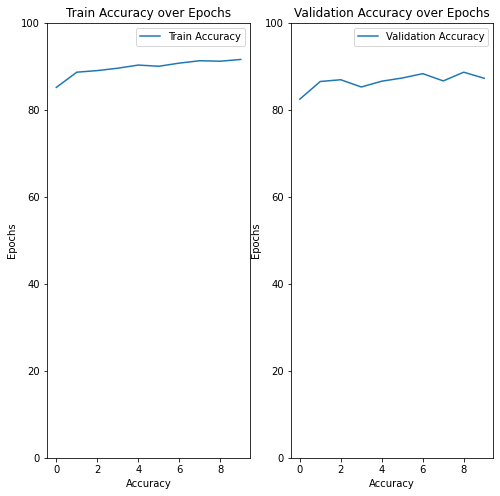

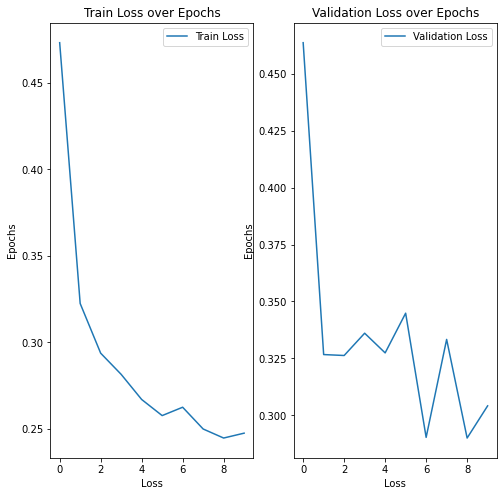

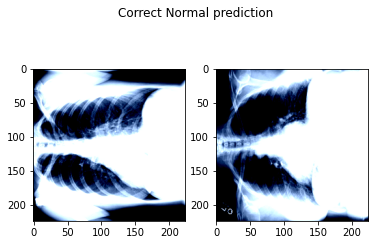

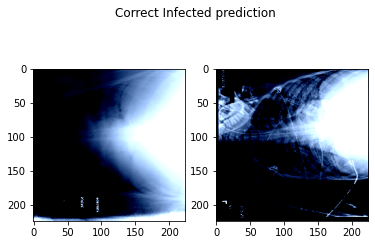

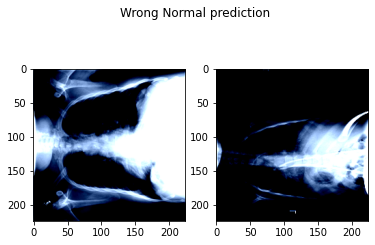

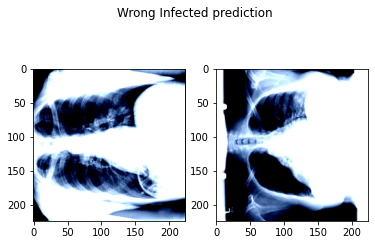

In [35]:
model_uc = res18

print( 'RESNET18 Model Training Started ')
model_training(model_loaded = res18,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.CrossEntropyLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=0.001, momentum=0.9),
               model_name_to_save = 'res18_entire_task2_selectedonly',
               plot_graphs = True)

print('\n  Test Accuracy : ')
_ = calculate_accuracy(testloader , "Testing", model_uc)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)
Confusion_Matrix_F1(testloader       , "Testing"   , model_uc)

print('\n  Images :')
right_and_wrong_images(testloader       , "Testing", model_uc)